Import des librairies nécessaire au bon fonctionnement du projet

In [1]:
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tarfile
from os import path
from tensorflow.keras import layers
from tensorflow import keras
import python_splitter
import shutil
from tensorflow.keras.models import load_model

import zipfile
from PIL import Image
from bs4 import BeautifulSoup

from PIL import Image
import cv2
from tensorflow.keras.models import Model
from keras import callbacks

import shutil
import numpy as np

Activation de l'utilisation du GPU

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Téléchargement du dataset

In [3]:
if not path.isdir('dataset'):
    data_dir = tf.keras.utils.get_file(
        "dataset.tar",
        "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar",
        extract=False)
    with tarfile.open(data_dir, 'r') as tar_ref:
        tar_ref.extractall(path='/data/dataset/')
    print('Dataset installé')
else:
    print('Dataset déja installé')

Dataset déja installé


Import d'annotation concernant les images du dataset

In [4]:
if not path.isdir('annotation'):
    data_dir = tf.keras.utils.get_file(
        "annotation.tar",
        "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar",
        extract=False)
    with tarfile.open(data_dir, 'r') as tar_ref:
        tar_ref.extractall(path='/data/annotation/')
    print('Dataset installé')
else:
    print('Dataset déja installé')

Dataset déja installé


Première phase de prétraitement qui consiste à isoler les chiens dans les images afin de limiter les informations superflu

In [5]:
if path.isdir('custom_dataset'):
    shutil.rmtree("custom_dataset")
os.mkdir('custom_dataset')
os.mkdir('custom_dataset/Images')

directories = os.listdir('annotation/Annotation')
for directory in directories:
    os.mkdir('custom_dataset/Images/' + directory)
    files = os.listdir('annotation/Annotation/' + directory)
    for file in files:
        old_name = 'annotation/Annotation/' + directory + '/' + file
        new_name = 'annotation/Annotation/' + directory + '/' + file + '.xml'
        os.rename(old_name, new_name)
        if path.exists("dataset/Images/" + directory + '/' + file + '.jpg'):
            with open(new_name, 'r') as f:
                data = f.read()
            Bs_data = BeautifulSoup(data, "xml")
            boxes = Bs_data.find('xmin')
            for i in range(len(boxes)):
                xmin = int(str(Bs_data.find_all('xmin')[i]).replace('<xmin>', '').replace('</xmin>', ''))
                ymin = int(str(Bs_data.find_all('ymin')[i]).replace('<ymin>', '').replace('</ymin>', ''))
                xmax = int(str(Bs_data.find_all('xmax')[i]).replace('<xmax>', '').replace('</xmax>', ''))
                ymax = int(str(Bs_data.find_all('ymax')[i]).replace('<ymax>', '').replace('</ymax>', ''))
                image = Image.open(r"dataset/Images/" + directory + "/" + file + ".jpg")
                image = image.convert('RGB')
                image = image.crop((xmin, ymin, xmax, ymax))
                image.save("custom_dataset/Images/" + directory + "/" + file + ".jpg")
        os.rename(new_name, old_name)

Séparation du dataset en données d'entrainement, validation et test
python_splitter.split_from_folder a un bug et inverse le répertoire de test et de val donc il faut inverser les valeurs (voir pour changer la façon de split)

In [6]:
if path.isdir('Train_Test_Folder'):
    shutil.rmtree("Train_Test_Folder")
python_splitter.split_from_folder("/data/custom_dataset/Images", train = 0.7, test = 0.25)

✅Checking SOURCE directory...
0.7 0 0.25
✅Checking percentage validation...
✅Making required directories...
✅Shuffling data...
✅Getting ready for copying files...

-------------Successfully splitted !!!--------------- 


Création d'un tableau contenant toutes les races

In [7]:
items = os.listdir('custom_dataset/Images')
items.sort()
dog_categories = [];
for item in items:
    dog_categories.append(item.split('-')[1])

Import des batch d'images et redimensionnement

Found 14355 files belonging to 120 classes.
Found 1077 files belonging to 120 classes.
Found 5148 files belonging to 120 classes.


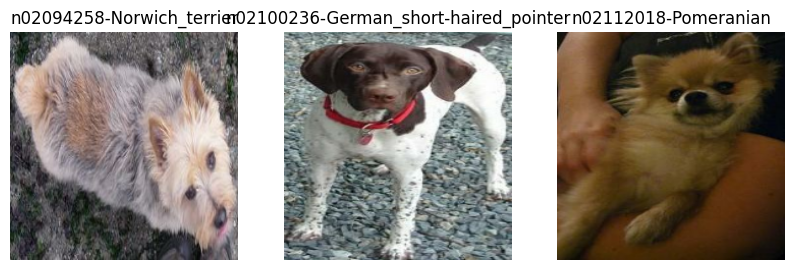

In [8]:
BATCH_SIZE = 32
IMG_SIZE = 224
NB_CLASS = 120
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/train'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/test'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/val'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Je transforme mes classes en un vecteur one hot

In [10]:
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=NB_CLASS)))
validation_dataset = validation_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=NB_CLASS)))
test_dataset = test_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=NB_CLASS)))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Seconde couche de prétraitement qui permet d'augmenter de manière artificielle le nombre de données d'entrainement

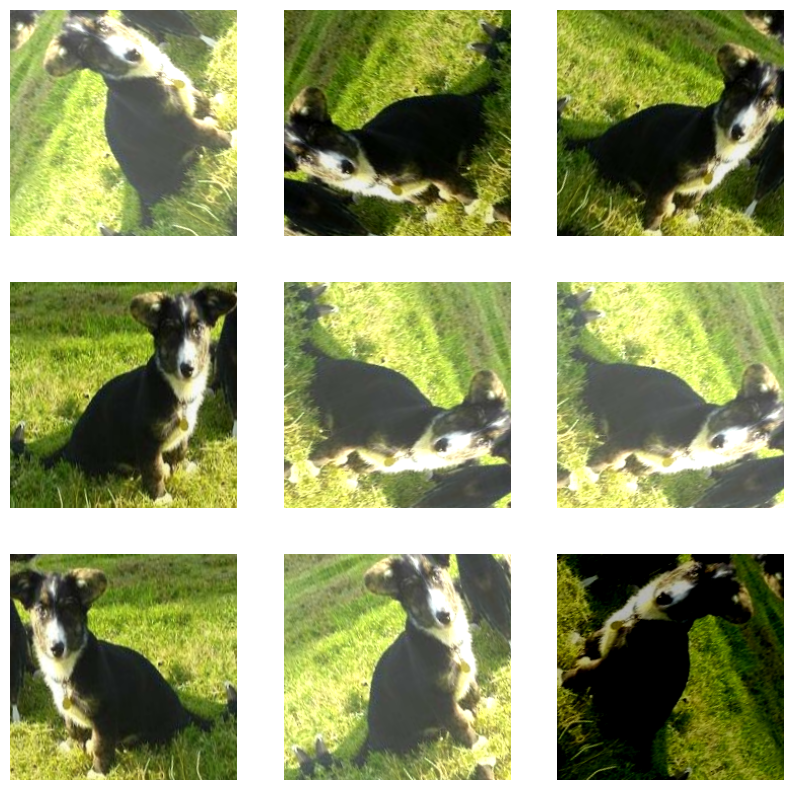

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness(0.3)
])

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Import de la deapfeature ResNet50V2 préentrainé sur les poids d'imagenet

In [12]:
base_model = keras.applications.ResNet50V2(
    include_top=False, # Exclude ImageNet classifier at the top
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = FalseJe gèle les poids pour qu'ils ne soient pas mis à jour durant l'entrainement du réseau

In [13]:
base_model.trainable = False

Contruction du modèle 

In [14]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

Je met une couche de normalisation afin que toute mes images aient le même niveau de flou

In [15]:
layers.GaussianNoise(stddev=0.2)(x)

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'gaussian_noise')>

J'intégre ma deapfeature

In [16]:
x = keras.applications.resnet_v2.preprocess_input(x)
x = base_model(x, training=False)

J'ajoute les couches permettant la classifications des races de chiens

In [17]:
x = layers.GlobalAveragePooling2D()(x) # Average pooling operation
x = layers.BatchNormalization()(x) # Introduce batch norm
x = layers.Dropout(0.8)(x)  # Regularize with dropout
outputs = layers.Dense(NB_CLASS, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

Je compile mon modèle 

In [18]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
)

Je met en place un métrique d'early stopping afin d'éviter le sur apprentissage
Si la fonction de perte sur mes données d'entrainement ne diminu pas significativement pendant 5 époques alors j'arrête l'entrainement et je restore les meilleurs poids pour le réseau

In [19]:
earlystopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    patience=5, 
    restore_best_weights=True,
    min_delta = 0.01
)

Définition d'une nouvelle métrique permettant d'obtenir la matrice de confusion entre les races de chiens

In [20]:
class raceConfondu(keras.callbacks.Callback):
    def __init__(self, val_data, dog_categories):
        super().__init__()
        self.validation_data = val_data
    def on_train_begin(self, logs={}):
        self._data = {
            'matric_confusion':  np.zeros((120,120))
        }

    def on_epoch_end(self, batch, logs={}):
        for x_test, y_test in self.validation_data:
            y_predict = np.asarray(model.predict(x_test, verbose=0))

            true = np.argmax(y_test, axis=1)
            pred = np.argmax(y_predict, axis=1)
            predictions = zip(true, pred);
            for test, prediction in predictions:
                self._data['matric_confusion'] =  np.add(self._data['matric_confusion'], tf.math.confusion_matrix([test], [prediction], 120))
        return

    def get_data(self):
        return self._data
    
raceConfondu = raceConfondu(val_data = validation_dataset, dog_categories = dog_categories)

Début de l'entrainement du modèle sur 5 époques

In [21]:
EPOCHS = 5

history = model.fit(
    train_dataset, 
    epochs=EPOCHS, 
    validation_data=validation_dataset, 
    verbose=1,
    callbacks =[earlystopping, raceConfondu]
)

Epoch 1/5
449/449 [==============================] - 353s 721ms/step - loss: 4.1097 - categorical_accuracy: 0.2378 - val_loss: 0.8100 - val_categorical_accuracy: 0.7576
Epoch 2/5
449/449 [==============================] - 292s 650ms/step - loss: 2.5035 - categorical_accuracy: 0.4477 - val_loss: 0.6630 - val_categorical_accuracy: 0.7906
Epoch 3/5
449/449 [==============================] - 295s 645ms/step - loss: 2.3067 - categorical_accuracy: 0.4879 - val_loss: 0.6441 - val_categorical_accuracy: 0.8048
Epoch 4/5
449/449 [==============================] - 284s 633ms/step - loss: 2.1572 - categorical_accuracy: 0.5156 - val_loss: 0.6308 - val_categorical_accuracy: 0.8036
Epoch 5/5
449/449 [==============================] - 306s 649ms/step - loss: 2.0783 - categorical_accuracy: 0.5262 - val_loss: 0.5897 - val_categorical_accuracy: 0.8180


Affiche permettant de savoir avec quelles races une autre race est majoritairement confondu

In [22]:
race_confondu = {}
for dog_category in dog_categories:
    race_confondu[dog_category] = {}
i = 0
for row in raceConfondu.get_data()['matric_confusion']:
    for predict in np.where(row != 0)[0]:
        if predict == i:
            continue
        race_confondu[dog_categories[i]][dog_categories[predict]] = row[predict]
    i += 1
    
race_confondu

{'Chihuahua': {'Pekinese': 2.0,
  'papillon': 12.0,
  'toy_terrier': 14.0,
  'Italian_greyhound': 5.0,
  'Boston_bull': 8.0,
  'kelpie': 1.0,
  'French_bulldog': 3.0,
  'Pomeranian': 8.0,
  'Brabancon_griffon': 2.0,
  'Pembroke': 5.0,
  'Mexican_hairless': 5.0,
  'dingo': 4.0},
 'Japanese_spaniel': {'Pekinese': 12.0,
  'Shih': 1.0,
  'Blenheim_spaniel': 6.0,
  'papillon': 2.0,
  'English_springer': 5.0,
  'Saint_Bernard': 1.0},
 'Maltese_dog': {'Shih': 2.0,
  'Sealyham_terrier': 2.0,
  'cairn': 2.0,
  'Dandie_Dinmont': 9.0,
  'soft': 3.0,
  'West_Highland_white_terrier': 1.0,
  'Lhasa': 2.0,
  'Old_English_sheepdog': 2.0,
  'toy_poodle': 5.0,
  'miniature_poodle': 3.0},
 'Pekinese': {'Chihuahua': 1.0,
  'Japanese_spaniel': 10.0,
  'Shih': 8.0,
  'Blenheim_spaniel': 1.0,
  'papillon': 1.0,
  'Brittany_spaniel': 4.0,
  'French_bulldog': 1.0,
  'pug': 2.0,
  'Leonberg': 1.0,
  'Newfoundland': 1.0},
 'Shih': {'Japanese_spaniel': 5.0,
  'Maltese_dog': 4.0,
  'Pekinese': 4.0,
  'miniature_sc